## Mortgage loans in the United States: Will your application be approved?

This notebook explores trends in mortgage loan applications in the United States during 2018 and 2019. The main objective is to determine which are the factors that are strongest in determining whether a mortgage loan application is accepted or rejected. Data is taken from the United States government's Consumer Financial Protection Bureau and the Federal Financial Institutions Examination Council (FFIEC), which provide access to mortgage loan data, following the 1975 Home Mortgage Disclosure Act (HMDA).

In an ideal world, securing a mortgage loan would be subject to objective metrics alone, such as loan-to-value ratio, personal income, or debt-to-income ratio. This notebook explores how complex the question can be: approval rates vary according to locality, and data on factors such as race and ethnicity suggests that access to mortgage loan is to a large extent reflective of existing systemic inequalities.

### Some general characteristics

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.float_format = '{:.2f}'.format #Setting changed for better visibility purposes
sns.set()

In [171]:
filename = '/Users/agm/Desktop/Capstone2/Data/2018_9_reduced.csv'
df = pd.read_csv(filename)

The data used here is a subset of that available through the Federal Financial Institutions Examination Council (FFIEC) website (https://ffiec.cfpb.gov/). This report only considers 2018 and 2019, and filters for mortgage data related to a) originated loans, b) applications that were approved but not accepted by applicants, and c) denied applications. Data is also restricted to loans for home purchases (thus excluding loans for home improvement, refinancing, or other purposes).

The data contains, altoghether, {{df.shape[0]}} rows and a selection of {{df.shape[1]}} features. More details on the selection criteria for features can be found in the Data Wrangling notebook of this project. Some summary statistics are provided for some key features of our dataset:

In [406]:
df.describe().T

In [5]:
df[['loan_to_value_ratio', 'loan_amount', 'loan_term', 'income']].describe().T

,count,mean,std,min,25%,50%,75%,max
loan_to_value_ratio,8393516.00,100.94,16991.71,0.00,80.00,91.70,96.50,35196000.00
loan_amount,8393516.00,278432.19,241297.06,5000.00,155000.00,225000.00,335000.00,98005000.00
loan_term,8393516.00,348.98,91.70,1.00,360.00,360.00,360.00,216000.00
income,8393516.00,156.03,3584.15,-84000.00,55.00,83.00,130.00,3365365.00


As expected, there is great variance in fields related to income and loan terms. This is a challenge when handling over 8 million mortgage loan records, where the frequency of outliers reflects the heterogeneous nature of the sample and the population.

For general informative purposes, a summary of the value counts of all features is included here:

In [16]:
#Value counts for each column
for column in df.columns:
    print("\nFeature name:", column)
    print("Contains: ",len(df[column].value_counts()), "unique values")
    if len(df[column].value_counts()) < 10:
        print(df[column].value_counts().sort_values())


Feature name: activity_year
Contains:  2 unique values
2018    4155822
2019    4237694
Name: activity_year, dtype: int64

Feature name: lei
Contains:  3386 unique values

Feature name: state_code
Contains:  53 unique values

Feature name: county_code
Contains:  3217 unique values

Feature name: census_tract
Contains:  72468 unique values

Feature name: conforming_loan_limit
Contains:  2 unique values
NC     482407
C     7911109
Name: conforming_loan_limit, dtype: int64

Feature name: action_taken
Contains:  3 unique values
2     232300
3     714558
1    7446658
Name: action_taken, dtype: int64

Feature name: loan_type
Contains:  4 unique values
4     220785
3     738513
2    1679484
1    5754734
Name: loan_type, dtype: int64

Feature name: loan_amount
Contains:  810 unique values

Feature name: loan_to_value_ratio
Contains:  130074 unique values

Feature name: loan_term
Contains:  422 unique values

Feature name: property_value
Contains:  1436 unique values

Feature name: occupancy_ty

### Further actions for feature engineering

The summary statistics allow identifying further actions:
#### Conversion to categoricals

6. conforming_loan_limit: Can only be 'C' or 'NC'. Currently an object; will be changed to categorical (0/1).

7. action_taken: Can only be 1, 2, or 3. Currently an int. Will be changed to categorical (0/1) from 1 - Loan originated, 2 - Application approved but not accepted, and 3 - Application denied.

13. occupancy_type: Can only be 1, 2, or 3. Currently an int. Will be changed to categorical.

14. total_units: Four types. Currently an int. Will be converted to categorical.

16. debt_to_income_ratio: Binned values that limit universe to 19 categories. Currently an object. Will be converted to categorical.

17. applicant_ethnicity-1: Eight floats that correspond to a category. Currently a float; will be converted to categorical.

18. applicant_race-1: Eighteen floats that correspond to a category. Currently a float; will be converted to categorical.

19. applicant_sex: Five integers that correspond to a category; three error categories will be handled. Currently an int; will be converted to categorical.

20. applicant_age: Seven binned categories. Currently an int; will be converted to categorical.

21. submission_of_application: Four possible values. Two are error categories, which will be handled. Will be converted to categorical.

#### Further exploration

9. loan_amount: Contains outliers; how these will be handled, if at all, is TBD. Int64.

11. loan_term: Corresponds to month amount; Int64. Contains error values (e.g. 8888, 3630). Further investigation is warranted.

15. income: Contains outliers that are likely erroneous or extreme; income is expressed in thousands of dollars (e.g. negative incomes). To be investigated further. 

12. property_value: Contains outliers; how these will be handled, if at all, is TBD. Int64.

## Correlation heatmap

The correlation heatmap below suggests there is no one feature that is strongly correlated with our target variable, action_taken. There is a one-to-one correlation between county_code and census_tract, which are geographic markers; this is not a significant revelation, as it is expected that census tract numbers are labeled according to county codes. Other correlations exist between loan_amount and both tract_to_msa_income_percentage and ffiec_msa_md_median_family_income, which are in turn co-dependent on tract number; this suggests that there is a relationship between location and dollar amounts requested per loan.

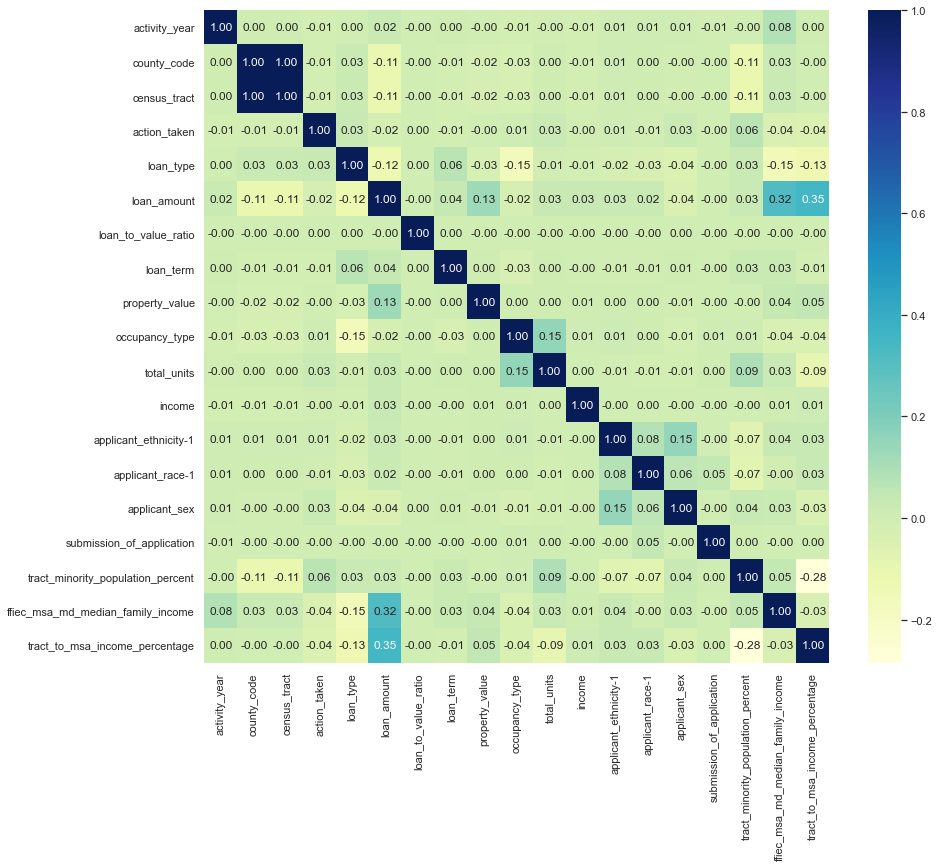

In [25]:
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, fmt='.2f')
plt.yticks(rotation=0);

### How are approval rates related to each feature?

In order to find any anomalies in our data -- that is, features or categories that seem to have unusual relationships with approval rates -- we explore the relationship between different features and approval rates. The features explored can be classified along two general types: 

* Numeric features: Features that are about economic and objective characteristics of the property, the applicant, and the loan. These include income, loan-to-value ratio, loan term, property value, property units.


* Subjective features: Features that, in theory, should not be a factor in the decision making process, including ethnicity, race, gender, state of residence.

Each type of feature is analyzed below.

In [172]:
#The following section modifies some of our feature values for consistency. 

#Action_taken converted to a binary variable: 0 if the loan application was rejected and 1 if it was accepted.
df.action_taken = 1 * (df.action_taken < 3)

#Aggregating applicant_sex error codes into a single one
df.applicant_sex = df.applicant_sex * (df.applicant_sex < 3)

#Aggregating N/A ethnicities
df['applicant_ethnicity-1'] = df['applicant_ethnicity-1'] * ((df['applicant_ethnicity-1'] < 3) | (df['applicant_ethnicity-1'] > 4))

#Aggregating N/A races
df['applicant_race-1'] = df['applicant_race-1'] * ((df['applicant_race-1'] < 6) | (df['applicant_race-1'] > 7))

In [489]:
#Function for handling features with outliers that skew results and complicate visualization
def subset_by_iqr(df, column, whisker_width=1.5):
    """Remove outliers from a dataframe by column, including optional 
       whiskers, removing rows for which the column value are 
       less than Q1-1.5IQR or greater than Q3+1.5IQR.
    Args:
        df (`:obj:pd.DataFrame`): A pandas dataframe to subset
        column (str): Name of the column to calculate the subset from.
        whisker_width (float): Optional, loosen the IQR filter by a
                               factor of `whisker_width` * IQR.
    Returns:
        (`:obj:pd.DataFrame`): Filtered dataframe
    """
    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter]                                                     

def plot_feature_acceptance_2 (feature, x_s=5, y_s=5, labels=[], p_type='bar'):
    '''Plots a bar chart of the acceptance rate of grouped features that require IQR subsetting to remove outliers'''
    temp = subset_by_iqr(df, feature, whisker_width=1.5)
    temp.loc[:,feature] = pd.qcut(temp[feature], q=10, duplicates='drop')
    tempo = temp.groupby(feature)['action_taken'].agg([('% accepted', lambda x: x.sum() / x.count() * 100)]).sort_values(by='% accepted', ascending=False).reset_index()
    tempo[feature] = tempo[feature].astype(str)
    plt.figure(figsize=(10,5))
    plt.ticklabel_format(style='plain')
    plt.xticks(range(0,100,5))
    plt.xlabel('Acceptance rate (%)')
    plt.ylabel(f"Feature: {feature}")
    if p_type == 'bar':
        if labels:
            plt.barh(width='% accepted', y=feature, data=tempo, 
                color=['navajowhite', 'darkseagreen', 'paleturquoise', 'skyblue', 'lightcoral', 'sandybrown'],
                tick_label=labels)
        else:
            plt.barh(width='% accepted', y=feature, data=tempo, 
                color=['navajowhite', 'darkseagreen', 'paleturquoise', 'skyblue', 'lightcoral', 'sandybrown'])

def plot_feature_acceptance (feature, x_s=5, y_s=5, labels=[], p_type='bar'):
    '''Plots a bar chart of the acceptance rate of grouped features'''
    temp = df.groupby(feature)['action_taken'].agg([('% accepted', lambda x: x.sum() / x.count() * 100)]).sort_values(by='% accepted', ascending=False).reset_index()
    plt.figure(figsize=(x_s,y_s))
    plt.ticklabel_format(style='plain')
    plt.xticks(range(0,100,5))
    plt.xlabel('Acceptance rate (%)')
    plt.ylabel(f"Feature: {feature}")
    if p_type == 'bar':
        if labels:
            plt.barh(width='% accepted', y=feature, data=temp, 
                color=['navajowhite', 'darkseagreen', 'paleturquoise', 'skyblue', 'lightcoral', 'sandybrown'],
                tick_label=labels)
        else:
            plt.barh(width='% accepted', y=feature, data=temp, 
                color=['navajowhite', 'darkseagreen', 'paleturquoise', 'skyblue', 'lightcoral', 'sandybrown'])
    else:
        plt.yticks(range(0,100,5))
        plt.ylabel('Acceptance rate (%)')
        plt.xlabel(f"Feature: {feature}")
        print("1:" , temp)
        temp = subset_by_iqr(temp, feature)
        print("2:" , temp)
        temp['bin'] = pd.qcut(temp[feature], q=10, precision=0).astype(str)
        print(temp.describe())
        plt.scatter(temp['bin'], temp['% accepted'])

### I. Numeric features

We begin with applicant income. The plot below catalogues applicant incomes in bins expressed by the thousand. As expected, the higher the income, the higher the acceptance rate.

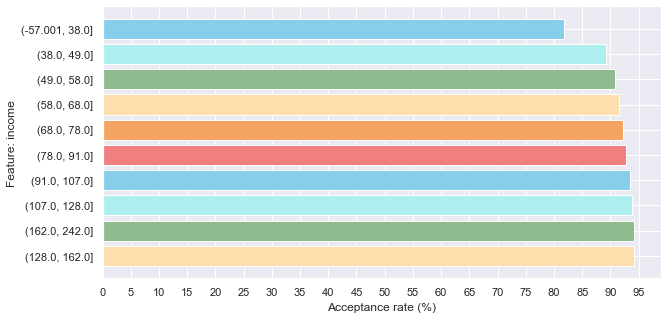

In [464]:
plot_feature_acceptance_2('income', x_s=10, y_s=5)

As the plot below shows, the property's total number of units is also a relevant factor that impacts approval rates.

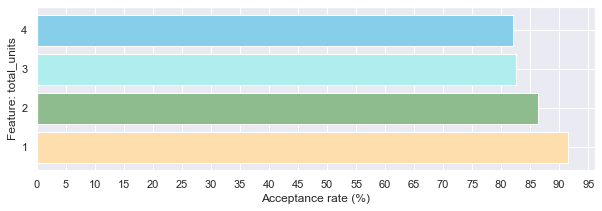

In [343]:
plot_feature_acceptance('total_units', x_s=10, y_s=3)

As in the case with income, we can expect certain common sense assumptions to be true: in this case, we observe that in general terms, the lower the loan-to-property-value ratio, the higher the likelihood of securing a loan.

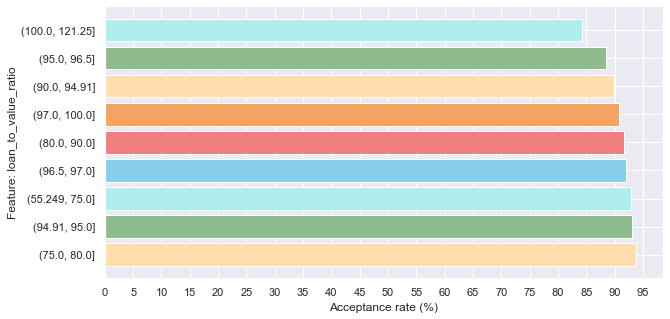

In [466]:
plot_feature_acceptance_2('loan_to_value_ratio', x_s=10, y_s=5)

Similarly, as the following plot demosntrates, the higher the property value, the higher chances of an acceptance -- this makes sense, considering applicants with higher incomes are more likely to attempt to buy more expensive properties.

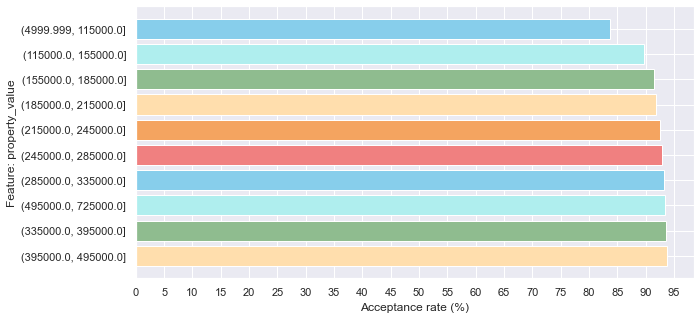

In [469]:
plot_feature_acceptance_2('property_value', x_s=10, y_s=5)

The same is true with loan terms: the longer the term, the less able or willing applicants are to pay faster, which indicates a weaker economic profile. It follows then that the shorter the term, the higher the acceptance rate.

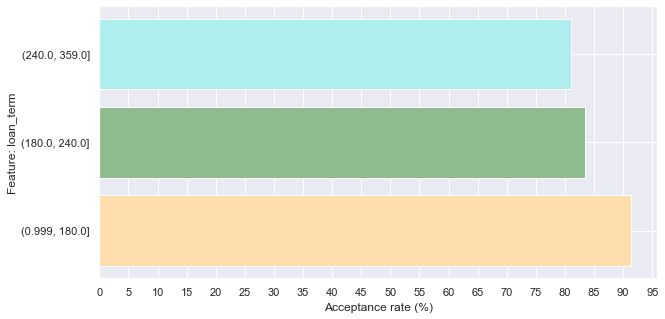

In [511]:
feature = 'loan_term'
w = df[df['loan_term'] < 360]
w.loc[:,feature] = pd.qcut(w[feature], q=10, duplicates='drop')
tempo = w.groupby(feature)['action_taken'].agg([('% accepted', lambda x: x.sum() / x.count() * 100)]).sort_values(by='% accepted', ascending=False).reset_index()
tempo[feature] = tempo[feature].astype(str)
plt.figure(figsize=(10,5))
plt.ticklabel_format(style='plain')
plt.xticks(range(0,100,5))
plt.xlabel('Acceptance rate (%)')
plt.ylabel(f"Feature: {feature}")
plt.barh(width='% accepted', y=feature, data=tempo, 
         color=['navajowhite', 'darkseagreen', 'paleturquoise', 'skyblue', 'lightcoral', 'sandybrown'])
plt.show()

As expected, an applicant's debt-to-income ratio is indeed a determining factor, as exemplified below:

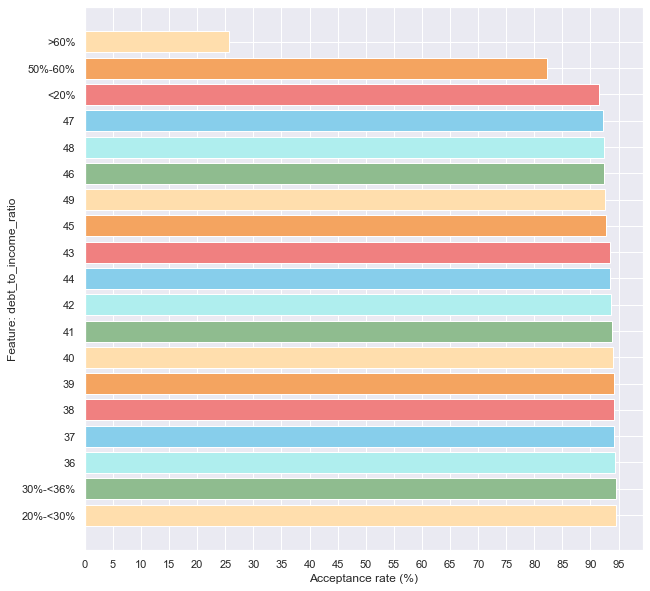

In [342]:
plot_feature_acceptance('debt_to_income_ratio', x_s=10, y_s=10)

### II. Subjective features

We begin with state code: To what extent does living in a certain territory affect approval rates? The plot below shows that PR (Puerto Rico) and Guam (GU) are at a significant disadvantage. It is hard to neglect that these two territories do not enjoy full statehood rights within the United States. This is already a telling discovery.

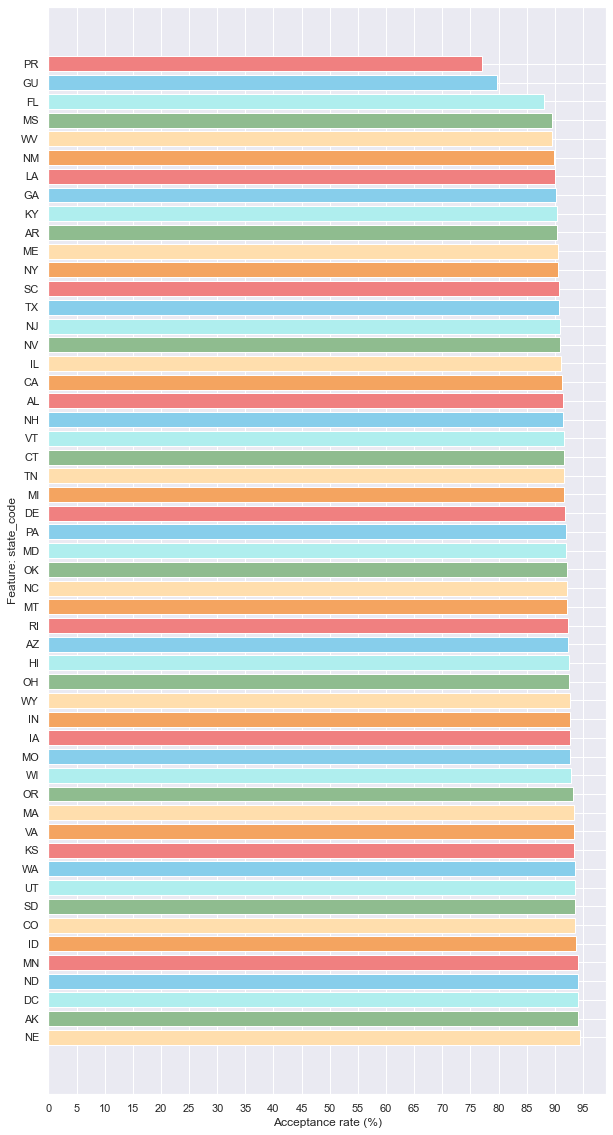

In [371]:
plot_feature_acceptance('state_code', x_s=10, y_s=20)

As the plot below suggests, ethnicity also appears to matter when it comes to securing a mortgage loan. While this plot does not suggest a clear-cut relation of causality, it warrants more investigation.

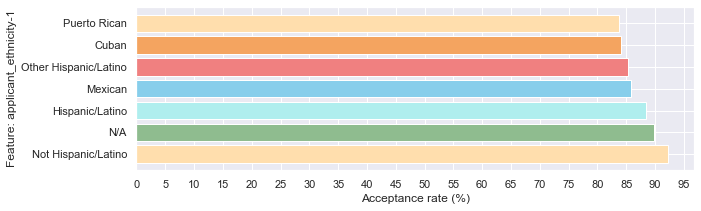

In [391]:
plot_feature_acceptance('applicant_ethnicity-1', x_s=10, y_s=3, labels=['Not Hispanic/Latino','N/A','Hispanic/Latino',
                                                                        'Mexican','Other Hispanic/Latino',
                                                                        'Cuban','Puerto Rican'])

As in the graph above, the following graph demonstrates that identity categories are indeed correlated to applicant acceptance rates. What might it mean that, in general, those who identify as Samoan have less acceptance rates than those who identify as White?

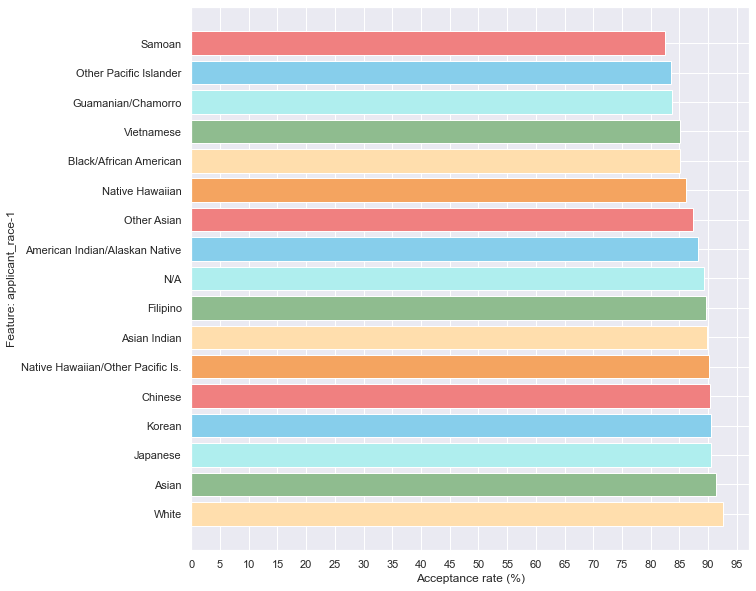

In [395]:
plot_feature_acceptance('applicant_race-1', x_s=10, y_s=10, labels=['White','Asian','Japanese','Korean','Chinese',
                                                                     'Native Hawaiian/Other Pacific Is.','Asian Indian',
                                                                     'Filipino','N/A','American Indian/Alaskan Native',
                                                                     'Other Asian','Native Hawaiian','Black/African American',
                                                                     'Vietnamese','Guamanian/Chamorro',
                                                                     'Other Pacific Islander','Samoan'])

The following plot shows differences in application rates according to applicant sex are not as significant as they are along ethnic and racial signs.

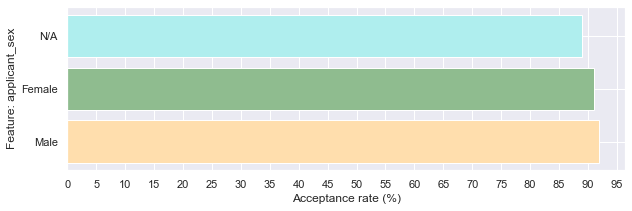

In [398]:
plot_feature_acceptance('applicant_sex', x_s=10, y_s=3, labels=['Male','Female','N/A'])

Similarly, as in the graphic that follows, acceptance rates do not vary as significantly according to age groups.

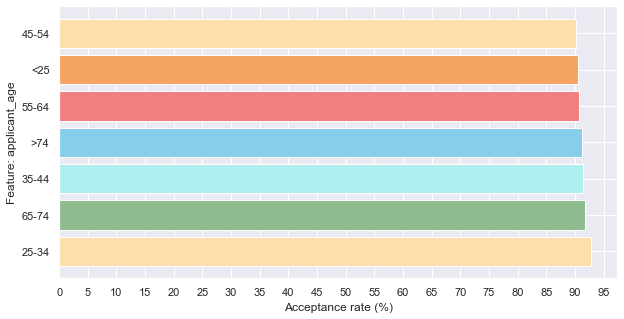

In [399]:
plot_feature_acceptance('applicant_age', x_s=10, y_s=5)

### Next steps

Model options will be explored that will allow understand the extent to which certain features related to mortgage loan applications affect loan outcomes.